In [1]:
import sys
sys.path.extend(['/Users/zsolt/Colloid_git/TractionRheoscopy'])
from data_analysis import static as da
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from importlib import reload

In [3]:
hdf_stem = '/Users/zsolt/Colloid/DATA/tfrGel10212018x/tfrGel10212018A_shearRun10292018f/locations_stitch/'
sed_fName = 'tfrGel10212018A_shearRun10292018f_sed_stitched.h5'
gel_fName = 'tfrGel10212018A_shearRun10292018f_gel_stitched.h5'

figPath = '/Users/zsolt/Colloid/DATA/tfrGel10212018x/tfrGel10212018A_shearRun10292018f/plots'

In [4]:
sedPos = da.loadData2Mem(hdf_stem + sed_fName)
sed_strainTraj_dt3 = pd.read_hdf(hdf_stem + '/{}'.format('tfrGel10212018A_shearRun10292018f_sed_strainTraj_dt3.h5'))
sed_strainTraj_refConfig = pd.read_hdf(hdf_stem + '/{}'.format('tfrGel10212018A_shearRun10292018f_sed_strainTrajZeroRef.h5'))

## Plot time series of strain in a selected region

- Define the region by selecting, 
    - for example particle with high von Mises Strain at a given time with a given dt in terms of strain
    - a further spatial selection to narrow it to some box where von Mises is sufficiently large 
    - Expand to include neighboring particles  
    
    ### or 
    
    - output von Mises strain in xyz files with absolute particle ids as well. 
    - plot in ovito
    - select particle ids and consider box around those particles. 
    
- Now plot 
    - the strain for all particles in the region as function of time regardless of when the von Mises strain spiked
    - the strain for only the particles that are part of the inclusion
    - the strain for only the particle **outside** the inclusion
    - xyz file with trajectory of the region
    - stress as function of time below the region. 

In [5]:
def vonMises(e11,e12,e13,e22,e23,e33): return np.sqrt(((e11-e22)**2 + (e22-e33)**2 + (e33-e11)**2 +6*(e12**2 + e23**2 + e13**2))/2)

# select only particle with more than 9 nnb
idx = sed_strainTraj_refConfig[sed_strainTraj_refConfig.loc[(slice(None),'nnb count'),:] >= 9].dropna().unstack().index
buf2 = sed_strainTraj_refConfig.unstack().reindex(idx)

# get components
exx = buf2.loc[:,buf2.columns.get_level_values(1) == 'exx'].droplevel(1,axis=1).to_numpy()
exy = buf2.loc[:,buf2.columns.get_level_values(1) == 'exy'].droplevel(1,axis=1).to_numpy()
exz = buf2.loc[:,buf2.columns.get_level_values(1) == 'exz'].droplevel(1,axis=1).to_numpy()
eyy = buf2.loc[:,buf2.columns.get_level_values(1) == 'eyy'].droplevel(1,axis=1).to_numpy()
eyz = buf2.loc[:,buf2.columns.get_level_values(1) == 'eyz'].droplevel(1,axis=1).to_numpy()
ezz = buf2.loc[:,buf2.columns.get_level_values(1) == 'ezz'].droplevel(1,axis=1).to_numpy()

# compute vonMises and form data frame
vonMises_np = vonMises(exx,exy,exz,eyy,eyz,ezz)
vonMises_df = pd.DataFrame(vonMises_np,index=idx,columns=buf2.loc[:,buf2.columns.get_level_values(1) == 'exx'].droplevel(1,axis=1).columns)

In [15]:
vonMises_df.columns[0:-3]
exx.shape
vonMises_df.shape
#coord = ['x (um, imageStack)', 'y (um, imageStack)','z (um, imageStack)']
#sedPos.xs(1,level='frame').loc[idx][coord]

(890920, 89)

In [16]:
# now loop over time and create tmp data frame of positions and von Mises strain values
coord = ['x (um, imageStack)', 'y (um, imageStack)','z (um, imageStack)']
f_stem = '/Users/zsolt/Colloid/DATA/tfrGel10212018x/tfrGel10212018A_shearRun10292018f/plots/vonMises_strain_traj'

n = 1
for t in vonMises_df.columns[0:-3]:
    out_df = sedPos.xs(n,level='frame').loc[idx][coord].join(vonMises_df[t]).dropna().sort_index(inplace=False)
    
    with open(f_stem + '/vonMises_refConfig_w_id_t{:02d}.xyz'.format(n),'w') as f:
        f.write(str(out_df.shape[0])+'\n\n')
        out_df.to_csv(f,sep=' ',header=False, index=True)
    
    n += 1

## Results from visualization in ovito 

After visualization in Ovito, I decided, as a first step to look at:
- particle ID 567167 to be inside an "inclusion"
- particle ID 565 963 to be outside the "inclusion"
  
The transoformation event occurs at approximately frame (0,4)  that is I expect to see a spike in von Mises for this particle at strain evaluated over absolute frame number 0 as reference as frame 4 as current. 

The steps after this are to:
- define the region over which I am going to look.
    - As a start consider all the particles within a generous cutoff distance from the center of the inclusion. 
    - of the N closest particles
    - in either method, set up a search tree and query the positions based on id. 
- partition the particles in high and low von Mises
- maybe subtract the mean over the volume and the mean over the sample
- look at the trajectories of the shear strain components 
- look at the trajectories of the hydrostatic pressure components

In [114]:
id_ovito = np.array([567164, 565963])
id_ovito

array([567164, 565963])

In [36]:
vonMises_df.loc[id_ovito]

,"(0,1)","(0,2)","(0,3)","(0,4)","(0,5)","(0,6)","(0,7)","(0,8)","(0,9)","(0,10)",...,"(0,80)","(0,81)","(0,82)","(0,83)","(0,84)","(0,85)","(0,86)","(0,87)","(0,88)","(0,89)"
particle,,,,,,,,,,,,,,,,,,,,,
567164,0.020683,0.029110,0.033115,0.105549,0.140338,0.148691,0.153959,0.160499,0.163823,0.154309,...,0.226261,0.214038,0.233706,0.215948,0.212972,0.237188,0.244512,0.232588,0.228626,0.234954
565963,0.011263,0.010042,0.013201,0.006750,0.018894,0.008480,0.017142,0.020303,0.018847,0.014505,...,0.021193,0.019854,0.038537,0.016292,0.025190,0.030085,0.029536,0.012030,0.019424,0.019788


<AxesSubplot:ylabel='567164'>

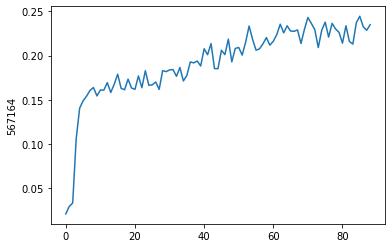

In [53]:
sns.lineplot(x=np.arange(89), y = vonMises_df.loc[id_ovito[0]])

In [70]:
buf = vonMises_df.loc[id_ovito].transpose()
buf = buf.set_index(np.arange(89))

In [29]:
vonMises_df.loc[id_ovito[0]].to_numpy().flatten()

array([0.01231457, 0.02351119, 0.01507527, 0.03158244, 0.03824797,
       0.04660104, 0.04398831, 0.05195077, 0.04861571, 0.04205426,
       0.04264015, 0.03341961, 0.05673417, 0.04010326, 0.03796068,
       0.04568026, 0.04305759, 0.04321066, 0.03534668, 0.04318938,
       0.04625745, 0.0477948 , 0.03973107, 0.04332184, 0.04080744,
       0.0454467 , 0.06102958, 0.05789039, 0.0490549 , 0.05610966,
       0.05659158, 0.05059428, 0.05525529, 0.06311552, 0.05531994,
       0.050085  , 0.04382473, 0.0536994 , 0.05271031, 0.05809586,
       0.05032809, 0.04944275, 0.06142511, 0.06272275, 0.06669881,
       0.05635536, 0.05370254, 0.05755978, 0.03771237, 0.06151099,
       0.05089693, 0.05651655, 0.05912986, 0.05936739, 0.06134316,
       0.06076881, 0.07217174, 0.04661945, 0.06392775, 0.05074372,
       0.06773395, 0.06267807, 0.08125539, 0.05927346, 0.06343599,
       0.04726335, 0.05937868, 0.0630466 , 0.0673704 , 0.0768553 ,
       0.08073473, 0.06833428, 0.05538345, 0.05655442, 0.05949

In [82]:
buf = buf.drop(columns='time')

<AxesSubplot:>

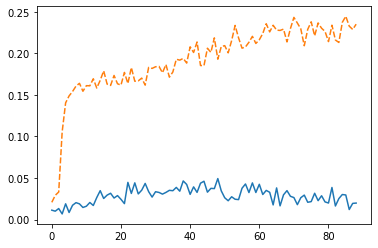

In [84]:
sns.lineplot( data=buf, legend=False)

### create a search tree and define the neighborhood

In [85]:
from scipy.spatial import cKDTree

In [88]:
refConfig = sedPos.xs(0,level='frame')[coord]

In [91]:
refTree = cKDTree(refConfig)

In [170]:
nnb_idx = pd.Index(refTree.query_ball_point(refConfig.loc[id_ovito[0]],10));

len(nnb_idx)
8/1315

0.006083650190114068

In [173]:
buf = vonMises_df.loc[idx.intersection(nnb_idx)].transpose().set_index(np.arange(89))

In [182]:
tmp = buf[0:10]
tmp

,562958,563077,563140,563257,563258,563260,563261,563405,563465,563466,...,899071,899096,899169,899254,899313,902253,902284,902293,902301,902306
0,0.019437,0.016428,0.019136,0.010701,0.022124,0.025854,0.037629,0.019914,0.009072,0.022974,...,0.018000,0.014792,0.033205,0.016039,0.015294,0.012017,0.034363,0.021170,0.019176,0.012236
1,0.028307,0.016075,0.013252,0.014978,0.024211,0.019863,0.012728,0.014105,0.009831,0.015889,...,0.018935,0.016047,0.011980,0.014112,0.022974,0.010568,0.014671,0.007589,0.026698,0.028007
2,0.023347,0.009445,0.009323,0.015845,0.034375,0.026503,0.035680,0.022006,0.019433,0.026320,...,0.015416,0.021774,0.023506,0.015566,0.023710,0.025107,0.021262,0.016829,0.020647,0.023715
3,0.019572,0.019920,0.019569,0.020711,0.036089,0.038043,0.014787,0.027587,0.015157,0.019992,...,0.035819,0.012635,0.021868,0.008636,0.013338,0.022279,0.018577,0.014750,0.027535,0.015140
4,0.043288,0.024039,0.020705,0.012906,0.045987,0.036623,0.022555,0.028467,0.031800,0.017761,...,0.026089,0.034018,0.023279,0.016348,0.025246,0.012949,0.019224,0.016872,0.049752,0.031779
5,0.036363,0.026279,0.026015,0.024192,0.026084,0.027812,0.035383,0.013495,0.022400,0.014967,...,0.016784,0.035523,0.023765,0.021065,0.020832,0.016708,0.019659,0.021270,0.046667,0.036932
6,0.012100,0.024445,0.025560,0.016607,0.027011,0.020663,0.023441,0.029925,0.017822,0.025387,...,0.025663,0.049142,0.015281,0.011415,0.022157,0.018962,0.033063,0.021499,0.063437,0.026418
7,0.033744,0.033211,0.020957,0.015616,0.040057,0.022059,0.028297,0.022933,0.014530,0.011087,...,0.021475,0.036264,0.019281,0.019659,0.022748,0.010641,0.030777,0.040453,0.052017,0.041787
8,0.020438,0.024894,0.021114,0.016845,0.044912,0.022867,0.035250,0.017735,0.015153,0.028895,...,0.017612,0.034711,0.016108,0.016283,0.022532,0.030228,0.032415,0.019409,0.054567,0.028873
9,0.026223,0.024908,0.020848,0.028582,0.041620,0.025451,0.029832,0.023190,0.032964,0.034937,...,0.026785,0.054799,0.025118,0.029734,0.016920,0.024778,0.040297,0.013129,0.055737,0.041596


<AxesSubplot:xlabel='45'>

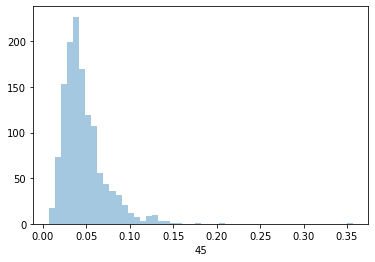

In [204]:
sns.distplot(buf.loc[45],kde=False)

In [231]:
buf.transpose().loc[buf.max() > 0.1].transpose().describe()

,564000,564078,564575,564710,564972,564976,564979,565063,565127,565184,...,898730,898818,898821,898861,898949,898972,899002,899066,902301,902306
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,...,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,0.075461,0.074587,0.121677,0.104629,0.116360,0.077817,0.109870,0.075283,0.100603,0.070640,...,0.109330,0.030580,0.079568,0.059990,0.058756,0.056496,0.085059,0.041357,0.084105,0.076442
std,0.018196,0.014433,0.027529,0.023671,0.026713,0.015125,0.022219,0.017100,0.023080,0.021153,...,0.037512,0.020656,0.020438,0.018834,0.019033,0.015132,0.024805,0.017491,0.027691,0.043275
min,0.019531,0.020277,0.006942,0.010320,0.018152,0.013740,0.013863,0.013565,0.008795,0.017150,...,0.020546,0.007907,0.006360,0.010014,0.009193,0.017361,0.034908,0.012126,0.019176,0.012236
25%,0.065806,0.070005,0.113513,0.100174,0.117765,0.074488,0.100341,0.071855,0.098727,0.053514,...,0.086198,0.019584,0.068036,0.049742,0.047205,0.047641,0.064724,0.030816,0.064391,0.041596
50%,0.076116,0.075823,0.128453,0.108128,0.122771,0.080285,0.111652,0.080328,0.104109,0.069190,...,0.109935,0.026286,0.081124,0.060573,0.057495,0.054999,0.086846,0.037600,0.080038,0.063331
75%,0.090007,0.082008,0.136720,0.120138,0.128500,0.085450,0.123272,0.085177,0.112999,0.089797,...,0.131234,0.035182,0.095003,0.067742,0.071930,0.064721,0.102396,0.046783,0.102586,0.112379
max,0.106605,0.104379,0.154948,0.134183,0.144831,0.103187,0.142253,0.107432,0.129036,0.110592,...,0.182944,0.121305,0.117759,0.112850,0.103383,0.102513,0.143195,0.103949,0.151959,0.176234


In [235]:
buf.transpose().loc[buf.max() > 0.12].describe()

,0,1,2,3,4,5,6,7,8,9,...,79,80,81,82,83,84,85,86,87,88
count,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,...,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000
mean,0.021599,0.022902,0.022364,0.045966,0.063095,0.066833,0.074261,0.079317,0.081093,0.082743,...,0.126263,0.123995,0.126101,0.125818,0.124129,0.131965,0.134044,0.133027,0.133499,0.133252
std,0.008859,0.008578,0.010335,0.029411,0.038614,0.038475,0.036395,0.037631,0.038759,0.038436,...,0.042649,0.040950,0.042469,0.042108,0.041391,0.042456,0.044351,0.041435,0.041479,0.040510
min,0.008448,0.004844,0.006942,0.011929,0.010257,0.018213,0.014675,0.015135,0.008363,0.011344,...,0.030966,0.030443,0.047886,0.041869,0.045406,0.073010,0.059559,0.066316,0.071513,0.070290
25%,0.015365,0.016353,0.014634,0.026030,0.034867,0.036309,0.052404,0.053907,0.052351,0.054733,...,0.106014,0.102414,0.108565,0.107620,0.107190,0.110342,0.112449,0.113785,0.112304,0.115483
50%,0.019999,0.021958,0.021239,0.037012,0.051171,0.062581,0.066696,0.075983,0.075908,0.082403,...,0.120119,0.120613,0.121723,0.120257,0.119735,0.126413,0.124844,0.127000,0.127799,0.126990
75%,0.025532,0.028914,0.025911,0.053084,0.078705,0.082765,0.090377,0.090917,0.106965,0.100806,...,0.136585,0.137732,0.133757,0.140620,0.137511,0.144256,0.144397,0.146038,0.140722,0.144584
max,0.048428,0.046405,0.055567,0.173296,0.235193,0.231927,0.235382,0.246505,0.247247,0.247720,...,0.421581,0.397452,0.419641,0.413956,0.411793,0.429431,0.441069,0.423526,0.432628,0.424182


<AxesSubplot:>

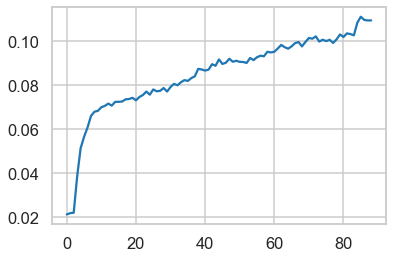

In [458]:
sns.lineplot(data=buf.transpose().loc[(buf.max() > 0.1) ].describe().loc['mean'])

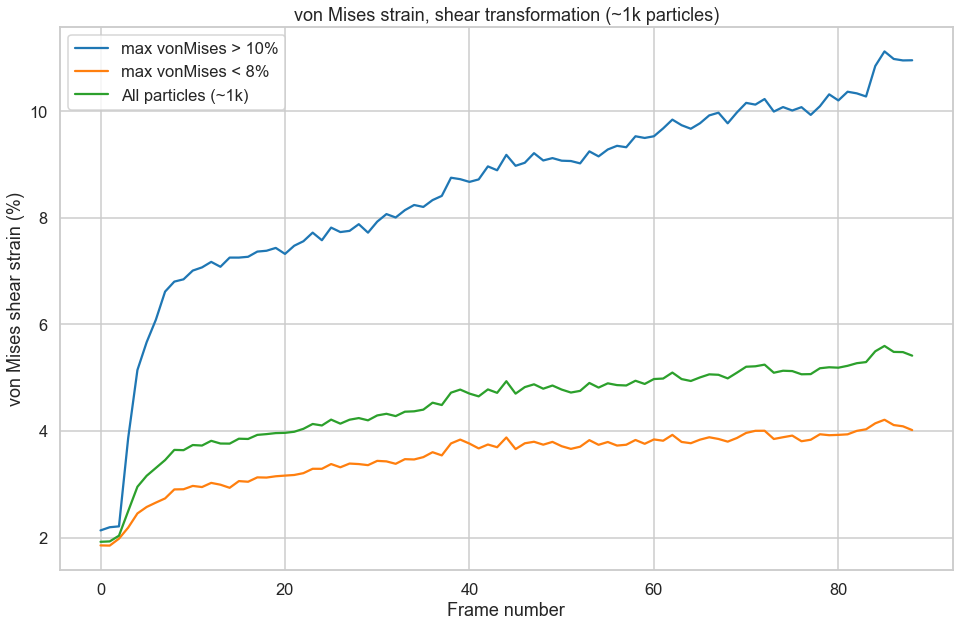

In [466]:
sns.set_context("talk")
f = plt.figure(figsize=(16,10))
g = sns.lineplot(data=100*buf.transpose().loc[(buf.max() > 0.1)].describe().loc['mean'], label ='max vonMises > 10%')
g.set(ylabel="von Mises shear strain (%)", xlabel="Frame number",title="von Mises strain, shear transformation (~1k particles)")
sns.lineplot(data=100*buf.transpose().loc[(buf.max() < 0.08)].describe().loc['mean'], label = 'max vonMises < 8%')
sns.lineplot(data=100*buf.transpose().loc[(buf.max() > 0)].describe().loc['mean'], label ='All particles (~1k)')
f.savefig("/Users/zsolt/Colloid/DATA/tfrGel10212018x/tfrGel10212018A_shearRun10292018f/plots/shearTransformationExample_vonMisesStrains.png")

In [247]:
## How does this compare to a random point
nnb_idx_random = pd.Index(refTree.query_ball_point(refConfig.loc[537567],10))
buf_random = vonMises_df.loc[idx.intersection(nnb_idx_random)].transpose().set_index(np.arange(89))

In [246]:
nnb_idx_random

Int64Index([535511, 536913, 536645, 535978, 548471, 545103, 537848, 537625,
            537963, 545758,
            ...
            559209, 561420, 553259, 559304, 553477, 559485, 561495, 553265,
            561390, 559449],
           dtype='int64', length=1349)

<AxesSubplot:xlabel='75'>

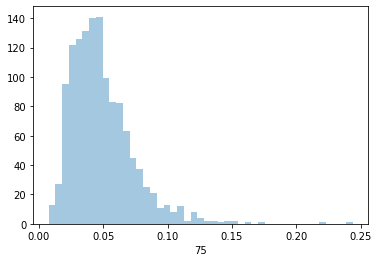

In [250]:
sns.distplot(buf_random.loc[75],kde=False)

<AxesSubplot:>

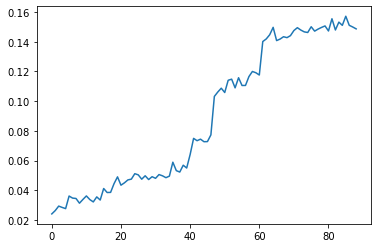

In [255]:
sns.lineplot(data=buf_random.transpose().loc[(buf_random.max() > 0.15)].describe().loc['mean'])

In [326]:
buf_exz = sed_strainTraj_refConfig.loc[(idx.intersection(nnb_idx),'exz'),:].transpose().set_index(np.arange(89))

<AxesSubplot:>

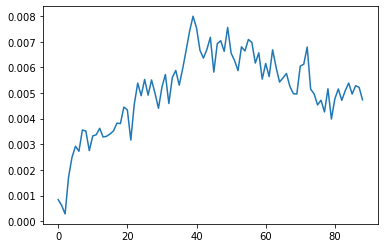

In [328]:
sns.lineplot(data= buf_exz.transpose().describe().loc['mean'])

0     0.019329
1     0.025617
2     0.021727
3     0.041879
4     0.050519
        ...   
84    0.073498
85    0.093003
86    0.074741
87    0.080352
88    0.080412
Length: 89, dtype: float64

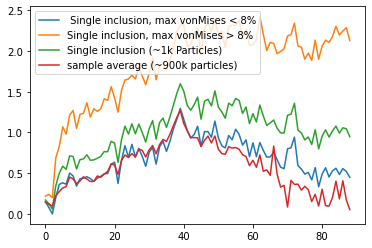

In [391]:
sns.lineplot(data=200*buf_exz.transpose().droplevel('values').loc[(buf.max() < 0.08) ].describe().loc['mean'], label=' Single inclusion, max vonMises < 8%')
sns.lineplot(data=200*buf_exz.transpose().droplevel('values').loc[(buf.max() > 0.08) ].describe().loc['mean'], label='Single inclusion, max vonMises > 8%')
sns.lineplot(data=200*buf_exz.transpose().droplevel('values').loc[(buf.max() < 0.50) ].describe().loc['mean'], label='Single inclusion (~1k Particles)')
sns.lineplot(data=200*sed_strainTraj_refConfig.loc[(slice(None),'exz'),:].droplevel('values').mean().reset_index(drop=True),label='sample average (~900k particles)')
buf.max() > 0.1
buf_exz.transpose().droplevel('values').loc[buf.max() > 0.1].max()

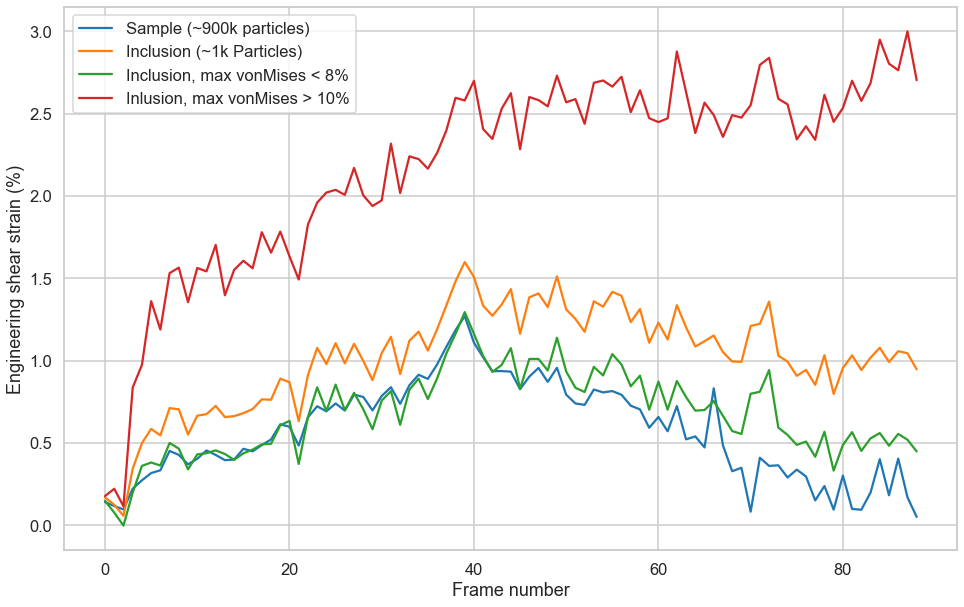

In [457]:
sns.set_context("talk")
f = plt.figure(figsize=(16,10))
sample = sns.lineplot(data=200*sed_strainTraj_refConfig.loc[(slice(None),'exz'),:].droplevel('values').mean().reset_index(drop=True),label='Sample (~900k particles)', legend=False)
sample.set(ylabel="Engineering shear strain (%)", xlabel="Frame number")
inclusion = sns.lineplot(data=200*buf_exz.transpose().droplevel('values').loc[(buf.max() < 0.50) ].describe().loc['mean'], label='Inclusion (~1k Particles)')
sns.lineplot(data=200*buf_exz.transpose().droplevel('values').loc[(buf.max() < 0.08) ].describe().loc['mean'], label='Inclusion, max vonMises < 8%')
sns.lineplot(data=200*buf_exz.transpose().droplevel('values').loc[(buf.max() > 0.1) ].describe().loc['mean'], label='Inlusion, max vonMises > 10%')
f.savefig("/Users/zsolt/Colloid/DATA/tfrGel10212018x/tfrGel10212018A_shearRun10292018f/plots/shearTransformationExample_split_vonMisesStrain.png")

In [380]:
sed_strainTraj_refConfig.loc[(slice(None),'exz'),:].droplevel('values').mean().reset_index(drop=True)
#sns.lineplot(data=200*sed_strainTraj_refConfig.loc[(slice(None),'exz'),:].droplevel('values').mean().reindex(np.arange(1,89)))

0     0.000704
1     0.000584
2     0.000479
3     0.001110
4     0.001363
        ...   
84    0.002006
85    0.000909
86    0.002024
87    0.000850
88    0.000252
Length: 89, dtype: float64

In [321]:
strain_traj_inclusionRegion = sed_strainTraj_refConfig.loc[(idx.intersection(nnb_idx),slice(None)),:]
strain_traj_randomRegion = sed_strainTraj_refConfig.loc[(idx.intersection(nnb_idx_random),slice(None)),:]

In [294]:
strain_traj_inclusionRegion.loc[(slice(None),'exx'),:].transpose().set_index(np.arange(89))

particle,562958,563077,563140,563257,563258,563260,563261,563405,563465,563466,...,899071,899096,899169,899254,899313,902253,902284,902293,902301,902306
values,exx,exx,exx,exx,exx,exx,exx,exx,exx,exx,...,exx,exx,exx,exx,exx,exx,exx,exx,exx,exx
0,-0.002668,0.001331,0.000507,0.005231,-0.000998,0.001960,0.005476,-0.006753,-0.003884,0.005487,...,-0.005881,-0.000688,0.003017,-0.001036,0.005188,0.000906,0.000225,-0.002581,-0.008421,0.005118
1,-0.000383,-0.001966,-0.004831,0.000870,0.002344,0.001392,0.001950,-0.004944,-0.007092,0.004774,...,-0.002587,0.005979,0.004334,-0.004224,0.007589,0.004810,-0.002450,0.004103,-0.013983,0.012060
2,0.002908,0.004624,-0.003013,0.000491,0.001789,-0.001163,0.001120,0.003878,-0.002630,0.009048,...,-0.000758,0.010731,0.010285,-0.000439,0.002077,0.004751,-0.000005,0.005787,-0.007102,0.004741
3,-0.003009,0.008536,0.005910,0.002015,0.007924,-0.004980,-0.000334,0.006002,-0.002261,0.007313,...,-0.007389,0.005226,0.006692,-0.003814,0.006865,0.002735,-0.005446,0.000070,-0.006870,0.009193
4,-0.006795,0.003594,0.000343,0.007749,0.003453,-0.007798,0.002089,0.002301,0.001151,0.003191,...,-0.005424,-0.027078,0.007211,-0.006593,-0.000192,0.005542,-0.006517,0.002935,0.028418,-0.004593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,-0.011141,0.007104,0.014048,-0.005185,0.006643,-0.004953,-0.004477,-0.004463,0.014271,0.006190,...,-0.002672,-0.001206,0.013686,0.013256,0.025985,0.018341,-0.002148,0.010729,0.009889,0.018738
85,-0.012762,0.011379,0.015193,0.000055,0.000259,-0.010999,-0.002393,-0.002212,0.012622,0.014097,...,0.002375,0.004658,0.012807,0.012647,0.028337,0.017107,0.001313,0.007366,0.012383,0.018451
86,-0.005183,0.013402,0.024261,-0.000730,0.004242,-0.004550,-0.006176,0.001171,-0.001380,0.008958,...,0.002545,-0.002788,0.020474,0.016015,0.019869,0.016589,-0.006949,0.001821,0.015546,0.013247


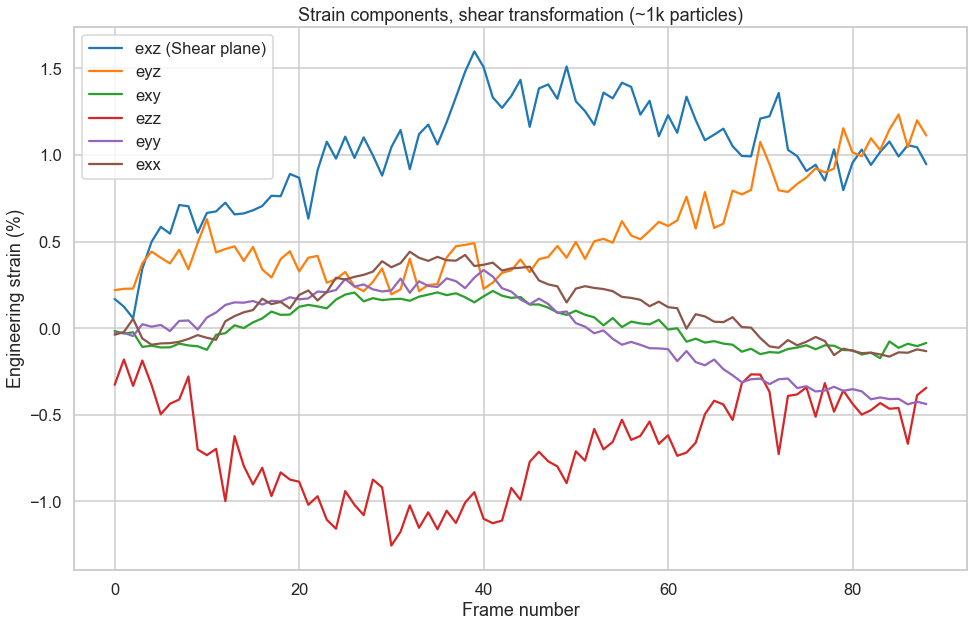

In [456]:
sns.set_context("talk")
f = plt.figure(figsize=(16,10))
g = sns.lineplot(data=200*strain_traj_inclusionRegion.loc[(slice(None),'exz'),:].transpose().set_index(np.arange(89)).transpose().describe().loc['mean'],label='exz (Shear plane)')
g.set(ylabel="Engineering strain (%)", xlabel="Frame number",title="Strain components, shear transformation (~1k particles)")
sns.lineplot(data=200*strain_traj_inclusionRegion.loc[(slice(None),'eyz'),:].transpose().set_index(np.arange(89)).transpose().describe().loc['mean'],label='eyz')
sns.lineplot(data=200*strain_traj_inclusionRegion.loc[(slice(None),'exy'),:].transpose().set_index(np.arange(89)).transpose().describe().loc['mean'],label='exy')
sns.lineplot(data=200*strain_traj_inclusionRegion.loc[(slice(None),'ezz'),:].transpose().set_index(np.arange(89)).transpose().describe().loc['mean'],label='ezz')
#sns.lineplot(data=200*buf_exz.transpose().droplevel('values').loc[(buf.max() < 0.50) ].describe().loc['mean'], label='exz, Inclusion (~1k Particles)')
sns.lineplot(data=200*strain_traj_inclusionRegion.loc[(slice(None),'eyy'),:].transpose().set_index(np.arange(89)).transpose().describe().loc['mean'],label='eyy')
sns.lineplot(data=200*strain_traj_inclusionRegion.loc[(slice(None),'exx'),:].transpose().set_index(np.arange(89)).transpose().describe().loc['mean'],label='exx')
f.savefig("/Users/zsolt/Colloid/DATA/tfrGel10212018x/tfrGel10212018A_shearRun10292018f/plots/shearTransformationExample_strainComponents.png")

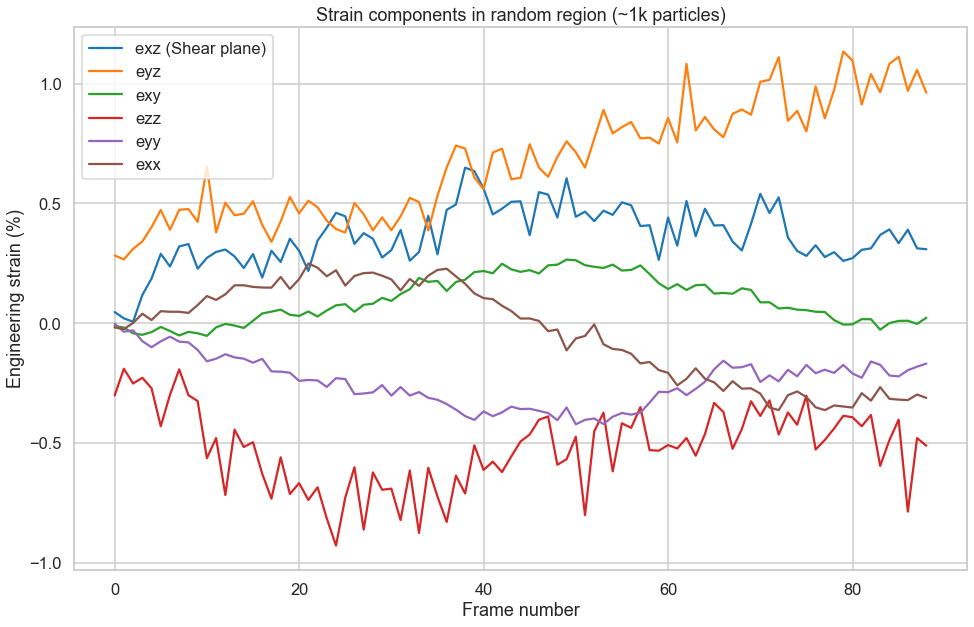

In [455]:
sns.set_context("talk")
f = plt.figure(figsize=(16,10))
g = sns.lineplot(data=200*strain_traj_randomRegion.loc[(slice(None),'exz'),:].transpose().set_index(np.arange(89)).transpose().describe().loc['mean'],label='exz (Shear plane)')
g.set(ylabel="Engineering strain (%)", xlabel="Frame number",title="Strain components in random region (~1k particles)")
sns.lineplot(data=200*strain_traj_randomRegion.loc[(slice(None),'eyz'),:].transpose().set_index(np.arange(89)).transpose().describe().loc['mean'],label='eyz')
sns.lineplot(data=200*strain_traj_randomRegion.loc[(slice(None),'exy'),:].transpose().set_index(np.arange(89)).transpose().describe().loc['mean'],label='exy')
sns.lineplot(data=200*strain_traj_randomRegion.loc[(slice(None),'ezz'),:].transpose().set_index(np.arange(89)).transpose().describe().loc['mean'],label='ezz')
sns.lineplot(data=200*strain_traj_randomRegion.loc[(slice(None),'eyy'),:].transpose().set_index(np.arange(89)).transpose().describe().loc['mean'],label='eyy')
sns.lineplot(data=200*strain_traj_randomRegion.loc[(slice(None),'exx'),:].transpose().set_index(np.arange(89)).transpose().describe().loc['mean'],label='exx')
f.savefig("/Users/zsolt/Colloid/DATA/tfrGel10212018x/tfrGel10212018A_shearRun10292018f/plots/random_region_strainComponents.png")

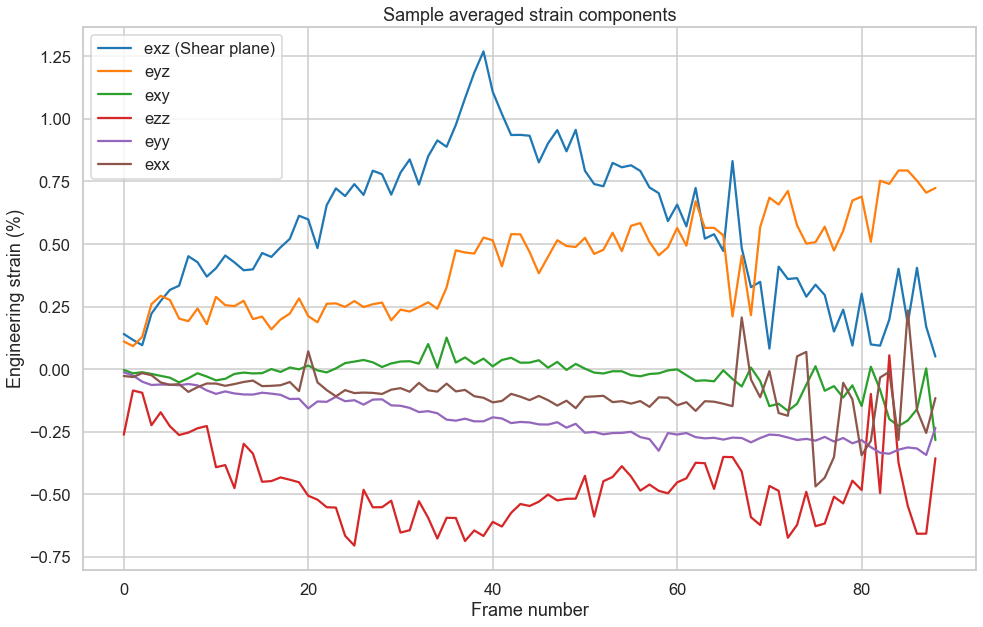

In [454]:
sns.set_context("talk")
f = plt.figure(figsize=(16,10))
g = sns.lineplot(data=200*sed_strainTraj_refConfig.loc[(slice(None),'exz'),:].droplevel('values').mean().reset_index(drop=True),label='exz (Shear plane)', legend=False)
g.set(ylabel="Engineering strain (%)", xlabel="Frame number",title="Sample averaged strain components")
sns.lineplot(data=200*sed_strainTraj_refConfig.loc[(slice(None),'eyz'),:].droplevel('values').mean().reset_index(drop=True),label='eyz', legend=False)
sns.lineplot(data=200*sed_strainTraj_refConfig.loc[(slice(None),'exy'),:].droplevel('values').mean().reset_index(drop=True),label='exy', legend=False)
sns.lineplot(data=200*sed_strainTraj_refConfig.loc[(slice(None),'ezz'),:].droplevel('values').mean().reset_index(drop=True),label='ezz', legend=False)
sns.lineplot(data=200*sed_strainTraj_refConfig.loc[(slice(None),'eyy'),:].droplevel('values').mean().reset_index(drop=True),label='eyy', legend=False)
sns.lineplot(data=200*sed_strainTraj_refConfig.loc[(slice(None),'exx'),:].droplevel('values').mean().reset_index(drop=True),label='exx')
f.savefig("/Users/zsolt/Colloid/DATA/tfrGel10212018x/tfrGel10212018A_shearRun10292018f/plots/sample_avg_strainComponents.png")